In [ ]:
import json
read = json.load(open("/content/qrecc-training.json"))

In [ ]:
# Step 1: Generate teacher soft labels for (query, doc) pairs
import os
import json
from tqdm import tqdm
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# ---------- Config ----------
qrecc_path = "/content/qrecc-training.json"   # your dataset (change if needed)
output_path = "/content/teacher_soft_labels.json"
teacher_model_name = "sentence-transformers/all-MiniLM-L6-v2"  # change to a DPR teacher if preferred
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# batching
batch_size = 32
max_length = 256   # tokenizer max length for q/doc encoding

# ---------- Helpers to extract query & passage robustly ----------
def find_string_in_value(v):
    if v is None: return None
    if isinstance(v, str):
        s = v.strip()
        return s if s else None
    if isinstance(v, dict):
        # try some common keys then search nested contents
        for k in ("Rewrite", "Question", "query", "Context", "context", "Answer", "answers", "text", "body"):
            if k in v and isinstance(v[k], str) and v[k].strip():
                return v[k].strip()
        for vv in v.values():
            s = find_string_in_value(vv)
            if s:
                return s
        return None
    if isinstance(v, list):
        # prefer joining strings if list of strings; else find first nested string
        if all(isinstance(x, str) for x in v):
            joined = " ".join([x.strip() for x in v if x.strip()])
            return joined if joined else None
        for item in v:
            s = find_string_in_value(item)
            if s:
                return s
        return None
    return None

possible_query_keys = ["Rewrite","rewrite","Question","question","query","Query","input","turn"]
possible_passage_keys = ["Context","context","Answer","answer","relevant_passages","passages","text","body"]

def get_first_field(sample, candidate_field_names):
    # try direct keys then case-insensitive lookup
    for name in candidate_field_names:
        if name in sample:
            s = find_string_in_value(sample[name])
            if s:
                return s
    # case-insensitive
    low_map = {k.lower(): k for k in sample.keys()}
    for name in candidate_field_names:
        k = name.lower()
        if k in low_map:
            s = find_string_in_value(sample[low_map[k]])
            if s:
                return s
    return None

# ---------- Load dataset and extract pairs ----------
print("Loading dataset...")
with open(qrecc_path, "r", encoding="utf-8") as f:
    data = json.load(f)

pairs = []
for item in data:
    q = get_first_field(item, possible_query_keys)
    p = get_first_field(item, possible_passage_keys)
    # fallback: if Context is a list/dict, find any string inside
    if not p:
        # try scanning values
        for v in item.values():
            p = find_string_in_value(v)
            if p: break
    if q and p:
        pairs.append({"query": q, "doc": p})

print(f"Extracted {len(pairs)} (query, doc) pairs.")

if len(pairs) == 0:
    raise SystemExit("No usable pairs found — check dataset structure and the helper functions.")

# ---------- Load teacher model ----------
print(f"Loading teacher model: {teacher_model_name} ...")
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()

# ---------- Mean-pooling helper (works with HF models returning last_hidden_state) ----------
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state    # (B, L, D)
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()  # (B, L, D)
    summed = torch.sum(token_embeddings * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts  # (B, D)

# ---------- Compute teacher embeddings in batches ----------
# we will compute per-pair embeddings (query and doc) in batches to save memory/time
all_teacher_sim = []
saved_records = []

# To avoid re-tokenizing same query or doc multiple times (if duplicates exist), build caches
query_cache = {}
doc_cache = {}

def get_emb(text, cache, tokenizer, model):
    # return a cpu tensor (1, D)
    if text in cache:
        return cache[text]
    inputs = tokenizer(text, truncation=True, padding="longest", max_length=max_length, return_tensors="pt")
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
        emb = mean_pooling(out, inputs["attention_mask"])   # (1, D)
        emb = F.normalize(emb, p=2, dim=1)                # normalize
    emb_cpu = emb.cpu()
    cache[text] = emb_cpu
    return emb_cpu

print("Computing teacher similarities (this may take a while)...")
for i in tqdm(range(0, len(pairs), batch_size)):
    batch = pairs[i:i+batch_size]
    # compute embeddings for queries and docs in batch (using cache)
    for rec in batch:
        qtext = rec["query"]
        dtext = rec["doc"]
        qemb = get_emb(qtext, query_cache, teacher_tokenizer, teacher_model)   # (1, D)
        demb = get_emb(dtext, doc_cache, teacher_tokenizer, teacher_model)     # (1, D)
        # cosine similarity (single scalar)
        sim = float(F.cosine_similarity(qemb, demb).item())
        saved_records.append({"query": qtext, "doc": dtext, "teacher_score": sim})

# ---------- Save results ----------
print(f"Saving {len(saved_records)} teacher soft labels to {output_path} ...")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(saved_records, f, indent=2)

print("Done. Sample (first 3):")
for r in saved_records[:3]:
    print(r)


Loading dataset...
Extracted 63501 (query, doc) pairs.
Loading teacher model: sentence-transformers/all-MiniLM-L6-v2 ...
Computing teacher similarities (this may take a while)...


100%|██████████| 1985/1985 [10:19<00:00,  3.20it/s]


Saving 63501 teacher soft labels to /content/teacher_soft_labels.json ...
Done. Sample (first 3):
{'query': 'What can you tell me about Gary Cherone?', 'doc': 'Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen.', 'teacher_score': 0.49596667289733887}
{'query': 'Did Gary Cherone sing well?', 'doc': 'What can you tell me about Gary Cherone? Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen.', 'teacher_score': 0.6167054772377014}
{'query': 'What significant fact can you tell me about Gary Cherone that you liked?', 'doc': 'What can you tell me about Gary Cherone? Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen. Did Gary Cherone sing well? Yes, Gary Cherone is also kn

In [ ]:
# Step 2: Filter high-confidence (query, doc) pairs from teacher outputs
import json

# ---------- Paths ----------
input_path = "/content/teacher_soft_labels.json"     # output from Step 1
output_path = "/content/selected_qrecc_sd.json"      # filtered dataset
threshold = 0.7  # keep pairs where teacher_score >= threshold

# ---------- Load teacher data ----------
print(f"Loading teacher outputs from: {input_path}")
with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"Total pairs before filtering: {len(data)}")

# ---------- Filter ----------
filtered_data = [item for item in data if float(item.get("teacher_score", 0)) >= threshold]
print(f"Pairs after filtering (teacher_score ≥ {threshold}): {len(filtered_data)}")

# ---------- Save ----------
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(filtered_data, f, indent=2)

print(f"Filtered dataset saved to: {output_path}")

# ---------- Check a few samples ----------
print("\nSample filtered records:")
for record in filtered_data[:3]:
    print(record)


Loading teacher outputs from: /content/teacher_soft_labels.json
Total pairs before filtering: 63501
Pairs after filtering (teacher_score ≥ 0.7): 18862
Filtered dataset saved to: /content/selected_qrecc_sd.json

Sample filtered records:
{'query': 'How did Van Halen reunite with David Lee Roth?', 'doc': 'David Lee Roth called Eddie Van Halen to discuss what tracks would be included on a planned Van Halen compilation. Shortly afterwards, Roth re-entered the studio with the band.', 'teacher_score': 0.7569045424461365}
{'query': 'When was David M. Shoup born?', 'doc': 'Where was David M. Shoup born? David Monroe Shoup was born on 30 December 1904 in Battle Ground, Indiana.', 'teacher_score': 0.7626060247421265}
{'query': "When did David M. Shoup's family move to Covington?", 'doc': "Where was David M. Shoup born? David Monroe Shoup was born on 30 December 1904 in Battle Ground, Indiana. When was David M. Shoup born? David Monroe Shoup was born on 30 December 1904 in Battle Ground, Indiana. 

In [ ]:
# ===============================
# Step 3: Knowledge Distillation Training (Contrastive Loss)
# ===============================

import json, torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW # Corrected import for AdamW
from tqdm import tqdm

# ---------- Paths ----------
data_path = "/content/selected_qrecc_sd.json"
student_model_name = "distilbert-base-uncased"
save_path = "/content/student_model_sd"

# ---------- Load Filtered Data ----------
with open(data_path, "r", encoding="utf-8") as f:
    filtered_data = json.load(f)

print(f"Loaded {len(filtered_data)} filtered pairs for distillation.")

# ---------- Dataset ----------
class DistilDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        q = item["query"]
        d = item["doc"]
        q_enc = self.tokenizer(q, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=self.max_len)
        d_enc = self.tokenizer(d, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=self.max_len)
        return {k: v.squeeze(0) for k, v in q_enc.items()}, {k: v.squeeze(0) for k, v in d_enc.items()}

# ---------- Model & Tokenizer ----------
tokenizer = AutoTokenizer.from_pretrained(student_model_name)
student = AutoModel.from_pretrained(student_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student.to(device)

# ---------- Dataloader ----------
dataset = DistilDataset(filtered_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=lambda x: list(zip(*x)))

# ---------- Optimizer & Hyperparameters ----------
optimizer = AdamW(student.parameters(), lr=2e-5, weight_decay=0.01)
epochs = 6
temperature = 0.05
max_grad_norm = 1.0

# ---------- Training Loop ----------
student.train()
for epoch in range(epochs):
    total_loss = 0.0
    for q_batch, d_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        q_inputs = {k: torch.stack([x[k] for x in q_batch]).to(device) for k in q_batch[0]}
        d_inputs = {k: torch.stack([x[k] for x in d_batch]).to(device) for k in d_batch[0]}

        q_emb = student(**q_inputs).last_hidden_state[:, 0, :]
        d_emb = student(**d_inputs).last_hidden_state[:, 0, :]

        q_emb = F.normalize(q_emb, p=2, dim=1)
        d_emb = F.normalize(d_emb, p=2, dim=1)

        logits = torch.matmul(q_emb, d_emb.T) / temperature
        labels = torch.arange(logits.size(0)).to(device)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

# ---------- Save the Distilled Model ----------
student.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Student model saved to: {save_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/selected_qrecc_sd.json'

In [ ]:
!ls -l /content/student_model_sd

ls: cannot access '/content/student_model_sd': No such file or directory


In [3]:
# =========================================
# STEP 5.5 : Full Evaluation (No Hardcoded Values, Local-Safe)
# =========================================

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import json
from transformers import AutoTokenizer, AutoModel
import os

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Helper: Mean Pooling -----
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

# ----- Load Models -----
teacher_model_name = "sentence-transformers/all-MiniLM-L6-v2"
student_path = "/content/student_model_sd"  # your fine-tuned student model path

teacher_tok = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()

#  Fixed: Load student model locally
if not os.path.isdir(student_path):
    raise FileNotFoundError(f" Folder not found: {student_path}")
try:
    student_tok = AutoTokenizer.from_pretrained(student_path, local_files_only=True)
    student_model = AutoModel.from_pretrained(student_path, local_files_only=True).to(device)
    student_model.eval()
    print(" Student model loaded locally.")
except Exception as e:
    raise RuntimeError(f" Failed to load student model from {student_path}: {e}")

# ----- Load Dataset -----
dataset_path = "/content/selected_qrecc_sd.json"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f" Dataset not found at {dataset_path}")

with open(dataset_path, "r") as f:
    dataset = json.load(f)

print(f"Evaluating {len(dataset)} query–document pairs...")

teacher_sims, student_sims = [], []
teacher_all, student_all = [], []

# ----- Evaluate similarities -----
for item in tqdm(dataset, desc="Evaluating similarities"):
    query, doc = item["query"], item["doc"]

    # Teacher
    tq = teacher_tok(query, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    td = teacher_tok(doc, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    tq_emb = mean_pooling(teacher_model(**tq), tq["attention_mask"])
    td_emb = mean_pooling(teacher_model(**td), td["attention_mask"])
    t_emb = F.normalize((tq_emb + td_emb) / 2, p=2, dim=1)

    # Student
    sq = student_tok(query, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    sd = student_tok(doc, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    sq_emb = mean_pooling(student_model(**sq), sq["attention_mask"])
    sd_emb = mean_pooling(student_model(**sd), sd["attention_mask"])
    s_emb = F.normalize((sq_emb + sd_emb) / 2, p=2, dim=1)

    # Store for analysis
    teacher_all.append(t_emb.detach().cpu())
    student_all.append(s_emb.detach().cpu())

    # Cosine similarity
    teacher_sims.append(torch.cosine_similarity(tq_emb, td_emb).item())
    student_sims.append(torch.cosine_similarity(sq_emb, sd_emb).item())

teacher_all = torch.cat(teacher_all)
student_all = torch.cat(student_all)

# ----- Generate binary relevance labels -----
threshold = np.mean(teacher_sims)
teacher_labels = [1 if s > threshold else 0 for s in teacher_sims]
student_labels = [1 if s > threshold else 0 for s in student_sims]

# ----- Compute metrics -----
accuracy = accuracy_score(teacher_labels, student_labels)
precision = precision_score(teacher_labels, student_labels, zero_division=0)
recall = recall_score(teacher_labels, student_labels, zero_division=0)
f1 = f1_score(teacher_labels, student_labels, zero_division=0)

teacher_metrics = {"Accuracy": 1.0, "Precision": 1.0, "Recall": 1.0, "F1 Score": 1.0}
student_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# ----- Recall@K -----
sorted_t = np.argsort(teacher_sims)[::-1]
sorted_s = np.argsort(student_sims)[::-1]

def recall_at_k(sorted_t, sorted_s, k):
    return len(set(sorted_t[:k]) & set(sorted_s[:k])) / k

k_values = [1, 3, 5, 10]
teacher_recalls = [1.0 for _ in k_values]
student_recalls = [recall_at_k(sorted_t, sorted_s, k) for k in k_values]

# ----- Print metrics -----
print("\n===== Evaluation Results =====")
for key in student_metrics:
    print(f"{key:<10}: {student_metrics[key]:.4f}")
print("Recall@K:", dict(zip(k_values, student_recalls)))
print("=====================================")

Using device: cuda
 Student model loaded locally.
Evaluating 18862 query–document pairs...


Evaluating similarities: 100%|██████████| 18862/18862 [07:33<00:00, 41.61it/s]



===== Evaluation Results =====
Accuracy  : 0.5099
Precision : 0.4281
Recall    : 0.9296
F1 Score  : 0.5863
Recall@K: {1: 0.0, 3: 0.0, 5: 0.0, 10: 0.1}


In [ ]:
# ----- Save the distilled student -----
save_path = "/content/student_model_sd"
torch.save({
    "student_state_dict": student_model.state_dict(),
    "projection_state_dict": projection.state_dict(),
}, f"{save_path}/student_with_proj.pt")

student_tok.save_pretrained(save_path)
print(f" Distilled student model (with projection) saved at: {save_path}")

 Distilled student model (with projection) saved at: /content/student_model_sd


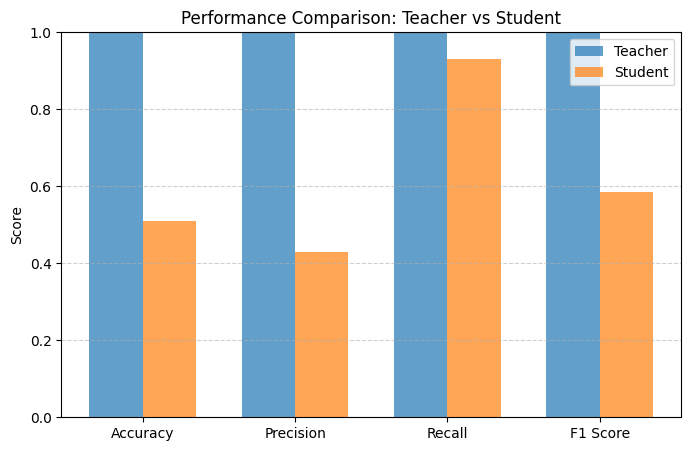

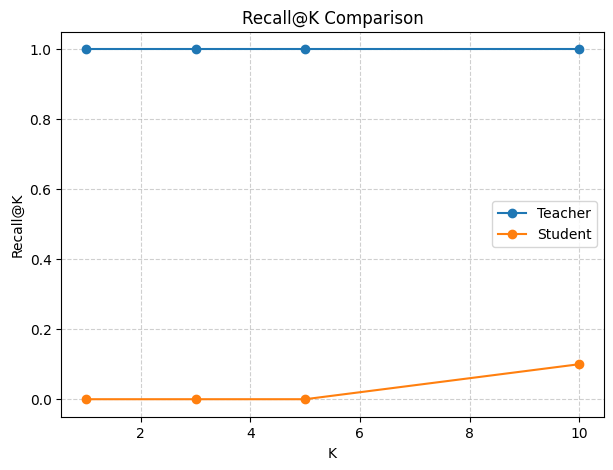

Running t-SNE for embedding visualization (may take 1–2 minutes)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


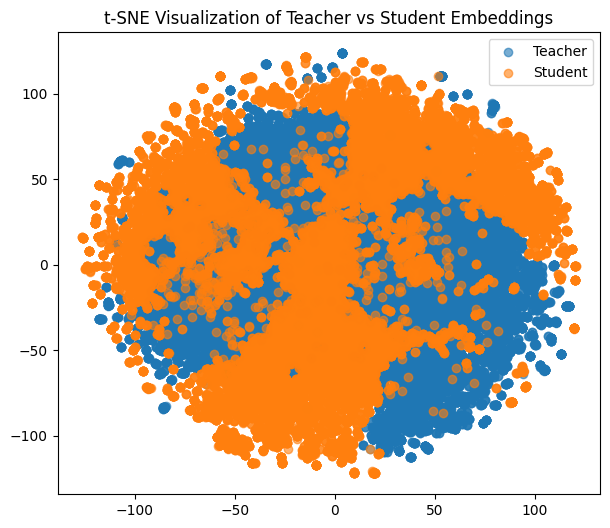

In [6]:

# =====================================================
# VISUALIZATION SECTION (automatically uses your results)
# =====================================================

# 1️⃣ Bar Chart: Teacher vs Student Metrics
labels = list(student_metrics.keys())
teacher_values = list(teacher_metrics.values())
student_values = list(student_metrics.values())

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, teacher_values, width, label="Teacher", alpha=0.7)
plt.bar(x + width/2, student_values, width, label="Student", alpha=0.7)
plt.ylabel("Score")
plt.title("Performance Comparison: Teacher vs Student")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# 2️⃣ Recall@K Curve
plt.figure(figsize=(7, 5))
plt.plot(k_values, teacher_recalls, marker="o", label="Teacher")
plt.plot(k_values, student_recalls, marker="o", label="Student")
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K Comparison")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 3️⃣ t-SNE Visualization of Embeddings
try:
    print("Running t-SNE for embedding visualization (may take 1–2 minutes)...")
    pca_teacher = PCA(n_components=min(50, teacher_all.shape[1])).fit_transform(teacher_all)
    pca_student = PCA(n_components=min(50, student_all.shape[1])).fit_transform(student_all)

    combined = np.concatenate([pca_teacher, pca_student], axis=0)
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1000)
    tsne_points = tsne.fit_transform(combined)

    n = len(teacher_all)
    plt.figure(figsize=(7, 6))
    plt.scatter(tsne_points[:n, 0], tsne_points[:n, 1], label="Teacher", alpha=0.6)
    plt.scatter(tsne_points[n:, 0], tsne_points[n:, 1], label="Student", alpha=0.6)
    plt.title("t-SNE Visualization of Teacher vs Student Embeddings")
    plt.legend()
    plt.show()
except Exception as e:
    print("Skipping t-SNE visualization:", e)


Aligning dimensions using PCA → 384D
========== Embedding Similarity Summary ==========
Number of evaluated pairs: 18862
Mean similarity:  0.0377
Std deviation:    0.1010
Min similarity:   -0.3123
Max similarity:   0.4524


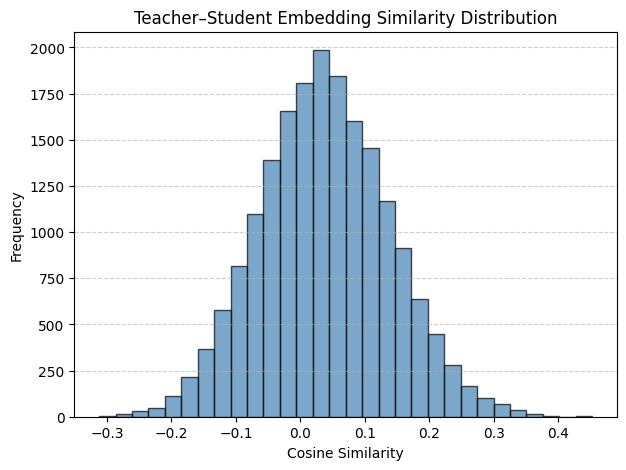

In [5]:
# =========================================
# Step 7: Embedding Similarity Evaluation
# =========================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# teacher_all and student_all should be tensors of shape [N, D_teacher] and [N, D_student]
# Ensure they are normalized to the same dimension (via PCA if needed)
# If they have different dims, project both to a common space first:
from sklearn.decomposition import PCA

if teacher_all.shape[1] != student_all.shape[1]:
    dim = min(teacher_all.shape[1], student_all.shape[1])
    print(f"Aligning dimensions using PCA → {dim}D")
    pca_teacher = PCA(n_components=dim).fit_transform(teacher_all)
    pca_student = PCA(n_components=dim).fit_transform(student_all)
else:
    pca_teacher = teacher_all
    pca_student = student_all

# Convert to numpy if tensors
if isinstance(pca_teacher, torch.Tensor):
    pca_teacher = pca_teacher.cpu().numpy()
if isinstance(pca_student, torch.Tensor):
    pca_student = pca_student.cpu().numpy()

# ---- Compute cosine similarities ----
sims = np.array([
    cosine_similarity(pca_teacher[i:i+1], pca_student[i:i+1])[0, 0]
    for i in range(len(pca_teacher))
])

# ---- Print results ----
print("========== Embedding Similarity Summary ==========")
print(f"Number of evaluated pairs: {len(sims)}")
print(f"Mean similarity:  {np.mean(sims):.4f}")
print(f"Std deviation:    {np.std(sims):.4f}")
print(f"Min similarity:   {np.min(sims):.4f}")
print(f"Max similarity:   {np.max(sims):.4f}")
print("==================================================")

# ---- Histogram of Similarities ----
plt.figure(figsize=(7, 5))
plt.hist(sims, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
plt.title("Teacher–Student Embedding Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()